The objective of this notebook is to do an basic exploratory analysis of the dataset and check its characteristics

## Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

In [3]:
df = pd.read_csv("../../data/bronze/raw_dataset.csv", )
df

,email,label
0,we are happy to present you the canadianpharma...,spam
1,to view the color version of this message or ...,ham
2,begin pgp signed message hash shaescapenumber...,ham
3,start date : 12 / 30 / 01 ; hourahead hour : 3...,ham
4,we are glad to present you this online softwar...,spam
...,...,...
94922,cheap oem soft shipping worldwide don ' t be ...,spam
94923,nomad international inc . ( ndin )\na multi - ...,spam
94924,looks like the extra letter was actually suppo...,ham
94925,below is the weekly western issues update sent...,ham


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94927 entries, 0 to 94926
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   94927 non-null  object
 1   label   94927 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


In [5]:
df.describe()


,email,label
count,94927,94927
unique,94447,2
top,"Sorry, I'll call later",ham
freq,30,48823


- We have a dataset with total amount of 94927 rows
- There are two unique categories: "ham" and "spam" and 94448 unique messages
- The most common category is "ham" that appears 48823 times and the most common message is "Sorry, I'll call later", a total of 30 times? wow, this sounds like whatsapp!

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94927 entries, 0 to 94926
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   94927 non-null  object
 1   label   94927 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


## Change data types

More specific data types consume less memory and allow more efficient data manipulation, etc. email column type is worthless since pandas uses "object" for strings too

In [ ]:


df['label'] = df['label'].map({"ham": 0, "spam": 1})
df['label'] = df['label'].astype('int8')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94927 entries, 0 to 94926
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   94927 non-null  object
 1   label   94927 non-null  int8  
dtypes: int8(1), object(1)
memory usage: 834.4+ KB


## Duplicated rows analysis

What is the amount of duplicated emails? And its percentage?

In [9]:
# create a dataframe with the duplicated rows grouped by label
duplicated_by_label = df[df.duplicated(keep=False)].groupby('label').size().rename("duplicated_by_label").reset_index()

# create a dataframe with the sum of rows of each label and change its name with total_rows
category_counts = df['label'].value_counts().reset_index()
category_counts.columns = ['label', 'total_rows_label']

#merge both dataframes
duplicated_by_label = duplicated_by_label.merge(category_counts, on='label')

#add a column with the percentage of duplicated per class
duplicated_by_label['total_rows_data'] = df.value_counts().sum()
duplicated_by_label['percent_duplicates_label'] = round(duplicated_by_label['duplicated_by_label'] / duplicated_by_label['total_rows_data'] * 100, 2)

duplicated_by_label

,label,duplicated_by_label,total_rows_label,total_rows_data,percent_duplicates_label
0,0,569,48823,94927,0.60
1,1,258,46104,94927,0.27


Oh wow, I expected the duplicates to be more present in the spam emails and the experience tells me that spam emails are generical and sent to everyone. This means that our dataset has been trimmed before published?

It would be interesting to understand the way these datasets were created and which sources they use for further analysis.

-----------

Are there emails that belong to both categories? I assume they are mistakes but in case we have them, we should check what's their origin


In [10]:
# create a dataframe with the duplicated emails grouped by email and filter them by unique value of label > 1, so one 0 label and one 1 label
emails_with_conflicting_labels = df[df.duplicated(keep=False)].groupby('email').filter(lambda x: x['label'].nunique() > 1)
emails_with_conflicting_labels

,email,label


There are none, that is a good symptom

## Distribution of the target feature

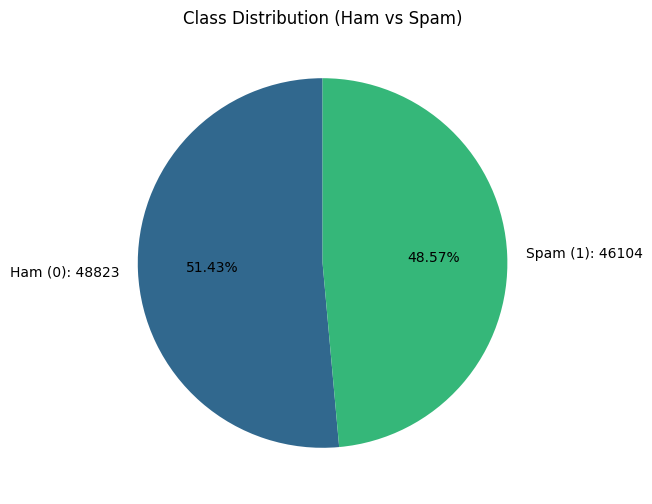

In [11]:
category_labels = ["Ham (0)", "Spam (1)"]
category_counts = df['label'].value_counts()

viridis_colors = sns.color_palette("viridis", len(category_counts))

plt.figure(figsize=(6, 6))
plt.pie(
    category_counts,
    labels=[f"{label}: {count}" for label, count in zip(category_labels, category_counts)], 
    autopct=lambda p: f"{p:.2f}%",  
    colors=viridis_colors,  
    startangle=90,  
)
plt.title("Class Distribution (Ham vs Spam)")
plt.show()


The dataset is quite balanced with the target class only containing a 48.57% of the class "SPAM" 

## Word count distribution

What is the distribution of the word count?

In [ ]:
df['word_count'] = df['email'].apply(lambda x: len(x.split()))
count_of_words = df.groupby(['word_count', 'label']).size().reset_index(name='count')
count_of_words

In [ ]:
count_of_words.tail(20)

In [ ]:
sns.boxplot(data=count_of_words, x='label', y='word_count', palette="viridis")

plt.xticks(ticks=[0, 1], labels=["Ham (0)", "Spam (1)"])
plt.title("Word Count Distribution by Label")
plt.xlabel("Label")
plt.ylabel("Word Count")
plt.show()

In [ ]:
lower_percentile = count_of_words['word_count'].quantile(0.05)
upper_percentile = count_of_words['word_count'].quantile(0.95)
filtered_data = count_of_words[
    (count_of_words['word_count'] >= lower_percentile) & 
    (count_of_words['word_count'] <= upper_percentile)
]
sns.boxplot(data=filtered_data, x='label', y='word_count', palette="viridis")
plt.xticks(ticks=[0, 1], labels=["Ham (0)", "Spam (1)"])
plt.title("Word Count Distribution by Label (Filtered Percentiles)")
plt.xlabel("Label")
plt.ylabel("Word Count")
plt.show()


## Char count distribution

In [ ]:
df['char_count'] = df['email'].apply(len)
df

In [ ]:

bins = np.arange(df['char_count'].min(), df['word_count'].max() + 20, 20)
sns.histplot(data=df, x='char_count', hue='email', bins=bins, kde=True, palette="viridis")
plt.title("Char Count Distribution by email")
plt.xlabel("Char Count")
plt.ylabel("Frequency")
plt.show()

## High char count distribution

In [ ]:
df_filtered = df[df['char_count'] >= 180]

bins = np.arange(df_filtered['char_count'].min(), df_filtered['char_count'].max() + 20, 20)
sns.histplot(data=df_filtered, x='char_count', hue='Category', bins=bins, kde=True, palette="viridis")
plt.title("Word Count Distribution by Category (30+ words)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

Observations:

- The distribution of HAM messages per char count shows that there are a lot os messages with very few characters ( <100 chars)
- The distribution of SPAM messages per char count shows that there are a lot of messages with more characters ( >100 chars)
- The SPAM distribution goes dramatically down after 150 chars
- There are no more SPAM messages when the count is higher than 223 chars
- HAM messages have more variability in number of chars than SPAM messages 

## Most common words in each class

For that I clean the text, tokenize and apply stopwords

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
import re
from string import punctuation

def clean_text(text):
    special_replacements = {
        r"£": "pound",
        r"\$": "dollar",
        r"\€": "euro",
        r"%": "percentage", 
        r"ì": "i",
        r"ü": "you",
        }
    
    emoticon_pattern = re.compile(r"""
    [:;=Xx]           
    [-~]?             
    [\)\]\(\[dDpP/]   
    """, re.VERBOSE)
    
    for pattern, replacement in special_replacements.items():
        text = re.sub(pattern, replacement, text)
    text = re.sub(emoticon_pattern, 'emoji', text)
    text = text.lower()
    text = re.sub('<[^<>]+>', ' ', text)
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub('[0-9]+', 'number', text)
    text = re.sub('[^\s]+@[^\s]+', 'emailaddr', text)
    text = text.translate(str.maketrans('', '', punctuation))
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_cleaned = df.copy()
df_cleaned['Message']=df_cleaned['Message'].apply(clean_text)
df_cleaned['message_tokenized'] = df_cleaned['Message'].apply(word_tokenize)

def remove_stopwords(tokens):
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_tokens)


df_cleaned['message_clean'] = df_cleaned['message_tokenized'].apply(remove_stopwords)
df_cleaned

In [ ]:
word = "I'm"

if word in stop_words:
    print(f"'{word}' is a stopword.")
else:
    print(f"'{word}' is not a stopword.")


In [ ]:
from collections import Counter

ham_data = df_cleaned[df_cleaned['Category'] == 0]
spam_data = df_cleaned[df_cleaned['Category'] == 1]

ham_words = Counter(" ".join(ham_data["message_clean"]).split()).most_common(20)
spam_words = Counter(" ".join(spam_data["message_clean"]).split()).most_common(20)

ham_words_list, ham_counts = zip(*ham_words)
spam_words_list, spam_counts = zip(*spam_words)

plt.figure(figsize=(12, 6))
plt.barh(ham_words_list, ham_counts, color="darkgreen")
plt.xlabel('Frecuencia')
plt.title('Top 20 most common words for HAM')
plt.tight_layout()

plt.figure(figsize=(12, 6))
plt.barh(spam_words_list, spam_counts, color="darkblue")
plt.xlabel('Frecuencia')
plt.title('Top 20 most common words for SPAM')
plt.tight_layout()

plt.show()


Notes:
Most common words in each class are different. That will help the model to differentiate between types of e-mails.

There is a lot of misspelling in both HAM and SPAM e-mails (u, ur, ill, etc), grammatical errors (poundnumber, numberp) and abbreviations (txt, ltgt? what does that even mean?) 


For the curious ones what Google says about "ltgt":
1. Long-Term Genistein Treatment in Biochemistry contexts.
2. Long-Term Growth in economy or investing
3. Less Than Greater Than in coding or math


In [ ]:
# pd.set_option('max_colwidth', None)

ltgt_means = df_cleaned[df_cleaned['message_tokenized'].apply(lambda x: 'ltgt' in x)]
ltgt_means['Message']

Notes: 

Ok, some of these messages are perturbing. Are there some that belong to SPAM?

In [ ]:
ltgt_means['Category'].value_counts()
